### Walgreen Stock Price Prediction

In [2]:
## import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**1. Loading the data from walgreen_data.csv file**

In [4]:
df = pd.read_csv('Walgreen_Stock.csv')

In [5]:
df.shape

(10468, 7)

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


**2. Data Preprocessing**

In [8]:
## Finding Null values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [10]:
## Converting the date column into datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


In [ ]:
## making date column as index
df.set_index('Date', inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10468 entries, 1980-12-12 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10468 non-null  float64
 1   High       10468 non-null  float64
 2   Low        10468 non-null  float64
 3   Close      10468 non-null  float64
 4   Adj Close  10468 non-null  float64
 5   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 572.5 KB


In [43]:
df.drop(df[df.index < pd.to_datetime('2018-08-15')].index, inplace=True)

In [44]:
df.shape

(968, 6)

In [45]:
## converting sequential data by sorting based on date
df = df.sort_index()

In [46]:
## Data Normalization 
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])

In [36]:
scaler_values

array([[4.30950014e-04, 4.33270567e-04, 4.42511906e-04, 4.35483696e-04,
        3.40815838e-04, 6.31981003e-02],
       [3.97331936e-04, 3.96658463e-04, 4.05118893e-04, 3.98684579e-04,
        3.12018225e-04, 2.36989104e-02],
       [3.48427437e-04, 3.47836857e-04, 3.55255959e-04, 3.49613594e-04,
        2.73615897e-04, 1.42459064e-02],
       ...,
       [7.35239774e-01, 7.50670228e-01, 7.37757535e-01, 7.44010911e-01,
        7.46069029e-01, 1.23332565e-02],
       [7.23135563e-01, 7.23604845e-01, 7.20334206e-01, 7.14499102e-01,
        7.16477939e-01, 1.45687326e-02],
       [7.12126738e-01, 7.27377614e-01, 7.24634207e-01, 7.22742631e-01,
        7.24743614e-01, 1.80712734e-02]], shape=(10468, 6))

In [47]:
## the above normalized values are in numpy array format, converting them into dataframe
df_scaled = pd.DataFrame(df, columns=df.columns, index=df.index)
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,52.305000,52.685001,52.082500,52.560001,50.707451,115230400
2018-08-16,52.937500,53.452499,52.867500,53.330002,51.450306,114001600
2018-08-17,53.360001,54.487499,53.290001,54.395000,52.477779,141708000
2018-08-20,54.525002,54.794998,53.777500,53.865002,51.966450,121150800
2018-08-21,54.200001,54.297501,53.507500,53.759998,51.865139,104639200


**3. Plotting the Columns**

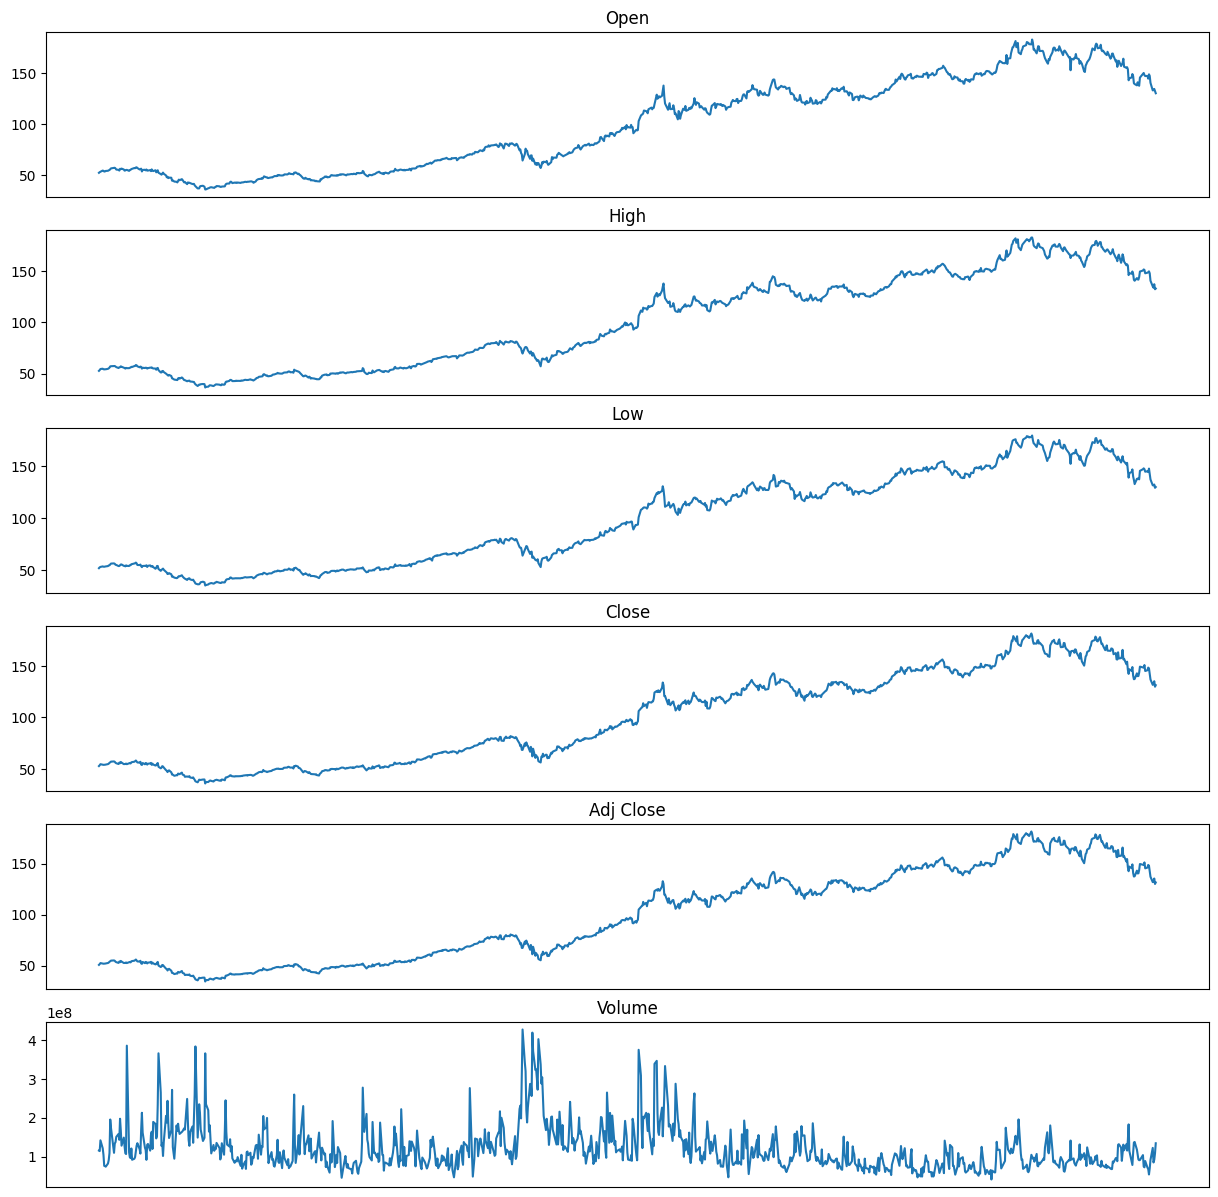

In [48]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, df_scaled.columns):
    ax.plot(df_scaled[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)

**4. Creating the sliding window sequences**

In [49]:
## [1,2,3,4.... 10]
# window_size = 3
# [1,2,3] => [4]
# [2,3,4] => [5]
# [3,4,5] => [6]

In [ ]:
def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(x), np.array(y)

In [64]:
X, y = create_sequence(df_scaled, window_size=60)

In [65]:
X.shape, y.shape

((908, 60, 6), (908, 6))